In [1]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Input, Flatten
from keras.callbacks import LambdaCallback
from keras.layers import Conv1D, MaxPooling1D, Embedding, Merge, Dropout,GlobalMaxPooling1D
from keras.models import Model
from keras import backend as K    
K.set_image_dim_ordering('th') 

/home/manoj/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
corpus = pd.read_pickle('../data/MR.pkl')
corpus= corpus.sample(frac=1)
sentences, labels = list(corpus.sentence), list(corpus.label)
print len(sentences)

10662


In [3]:
corpus.head(5)

,label,sentence,split
3349,0,would that greengrass had gone a tad less for ...,train
7469,1,you really have to salute writer director hane...,train
5345,1,"ultimately , it ponders the reasons we need st...",train
6917,1,"'no es la mejor cinta de la serie , ni la mejo...",train
4597,0,a movie to forget,train


In [4]:
#Increasing the value will increase sequence length in many sentences. Captures more words
TOP_N_WORDS = 5000

In [5]:
tokenizer = Tokenizer(nb_words=TOP_N_WORDS)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

/home/manoj/anaconda2/lib/python2.7/site-packages/keras/preprocessing/text.py:157: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 18758 unique tokens.


In [10]:
#Tokenizer.word_index shows the word and its index in the dictionary
#These indices are fed as a sequence
print (tokenizer.word_index.items()[:5])

[('aided', 12231), ('meeropol', 13454), ('writings', 7443), ('ryoko', 16422), ('foul', 3184)]


In [13]:
#This will show how the first sentence has been converted to numeric sequence
print sequences[0]
#This will show the first sentence itself
print "Sentence: "+sentences[0]
#This will loop through every word of the first sentence and see which word is not added in the sequence.
print "Comment: Words not added from the first sentence along with their ID`s"
words = sentences[0].split(" ")
for i in words:
    if i in word_index:
        if word_index[i] not in sequences[0]:
            print i, word_index[i]

[83, 10, 208, 560, 2, 156, 15, 3, 2, 204, 31, 15]
Sentence: would that greengrass had gone a tad less for grit and a lot more for intelligibility .
Comment: Words not added from the first sentence along with their ID`s
greengrass 5593
tad 7192
grit 7193
intelligibility 10106


In [14]:
max_sequence_length = 0
min_sequence_length = -1
j = -1
for i in sequences:
    seq_len = len(i)
    
    if min_sequence_length == -1:
        min_sequence_length = seq_len
        
    if seq_len > max_sequence_length:
        max_sequence_length = seq_len
    
    if seq_len < min_sequence_length and min_sequence_length!=-1:
        min_sequence_length = seq_len
        j = i
        
print min_sequence_length
print max_sequence_length

0
51


In [15]:
data = pad_sequences(sequences, maxlen=max_sequence_length)
import numpy as np
data_labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', data_labels.shape)

('Shape of data tensor:', (10662, 51))
('Shape of label tensor:', (10662, 2))


In [16]:
data[0]
data_labels[0]

array([1., 0.])

In [17]:
import os
GLOVE_DIR = "/home/manoj/Downloads/glove.6B/"
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print "Loaded "+str(len(embeddings_index))+" word embeddings from GLOVE"

Loaded 400000 word embeddings from GLOVE


In [18]:
EMBEDDING_DIM = len(embeddings_index["the"])

In [19]:
#+1 for bias.
#len(word_index) because we have so many unique tokens after all the filtering.

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be random numbers.
        embedding_matrix[i] = embedding_vector

In [20]:
embedding_matrix.shape

(18759, 100)

In [21]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=max_sequence_length,
                            trainable=True)

In [61]:
sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

x = (LSTM(50, return_sequences=True))(embedded_sequences)
x = (LSTM(40, return_sequences=True))(x)
x = Dropout(0.5)(x)
x = (LSTM(20, return_sequences=True))(x)
x = Dropout(0.5)(x)
x = (LSTM(10, return_sequences=True))(x)
x = GlobalMaxPooling1D()(x)
x = Dropout(0.5)(x)
x = Dense(2, activation="softmax")(x)

model = Model(sequence_input, x)

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [62]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 51)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 51, 100)           1875900   
_________________________________________________________________
lstm_26 (LSTM)               (None, 51, 50)            30200     
_________________________________________________________________
lstm_27 (LSTM)               (None, 51, 40)            14560     
_________________________________________________________________
dropout_16 (Dropout)         (None, 51, 40)            0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 51, 20)            4880      
_________________________________________________________________
dropout_17 (Dropout)         (None, 51, 20)            0         
__________

In [63]:
performance = model.fit(data, data_labels,epochs=10, batch_size=128, validation_split= 0.1)

Train on 9595 samples, validate on 1067 samples
Epoch 1/10
9595/9595 [==============================] - 20s 2ms/step - loss: 0.5975 - acc: 0.6783 - val_loss: 0.6229 - val_acc: 0.6757
Epoch 2/10
9595/9595 [==============================] - 16s 2ms/step - loss: 0.3713 - acc: 0.8642 - val_loss: 0.6603 - val_acc: 0.6982
Epoch 3/10
9595/9595 [==============================] - 16s 2ms/step - loss: 0.2611 - acc: 0.9089 - val_loss: 0.7411 - val_acc: 0.7067
Epoch 4/10
9595/9595 [==============================] - 16s 2ms/step - loss: 0.2340 - acc: 0.9126 - val_loss: 0.8590 - val_acc: 0.7067
Epoch 5/10
9595/9595 [==============================] - 16s 2ms/step - loss: 0.1896 - acc: 0.9298 - val_loss: 0.8707 - val_acc: 0.7113
Epoch 6/10
9595/9595 [==============================] - 17s 2ms/step - loss: 0.1843 - acc: 0.9351 - val_loss: 0.9971 - val_acc: 0.6954
Epoch 7/10
9595/9595 [==============================] - 17s 2ms/step - loss: 0.1653 - acc: 0.9391 - val_loss: 1.0559 - val_acc: 0.7010
Epoch 8

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline

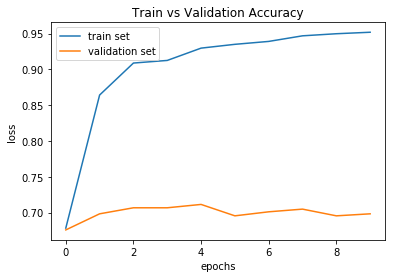

In [66]:
plt.plot(performance.history['acc'])
plt.plot(performance.history['val_acc'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train set', 'validation set'], loc='best')
plt.title('Train vs Validation Accuracy')